<a href="https://colab.research.google.com/github/Yar4ik000/DL_labs/blob/main/Morozov_DL_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Глубинное обучение. Лабораторная работа №2. Морозов Ярослав Олегович, 317

## Небольшая теоретическая и вводная части

С давних пор люди пытались решать задачи связанные с обработкой естественного языка с помощью различных классических моделей машинного обучения. Однако, как и ожидалось, результат оставлял желать лучшего. Главная проблема заключалась в том, что компьютер не умеет воспринимать слова как это делает человек, компьютер работаеть только с цифрами. Поэтому главное задачей в области работы с текстами стала проблема машинного представления слов. Классические методы по типу Bag of Words имели множество недостатков, поэтому человечеству хотелось найти что-то лучше. Появление нейросетей изменило ситуацию. Было желание создать такое представление слов, чтобы моделировалась ситуация "угадывания слова" по контексту, либо же, наоборот, угадывания контекста по слову. Для человека это почти очевидно - в предложении "На моем диване сидела ... и облизывалась" многие скажут, что таинственное многоточие - это какое-то из домашних животных, скорее всего кошка или собака. 

Одной из придуманных моделей стал так называемый word2vec - представление слов в каком-то n-мерном пространстве. Эта модель является неконтекстным представлением, однако неконтекстность здесь имеется в виду на этапе применения, обучение же, конечно, ведется с контекстом. 



<img src="https://lilianweng.github.io/posts/2017-10-15-word-embedding/word2vec-cbow.png">

Word2vec имеет два варианта реализации. Первая (на картинке выше), имеет под собой логику предсказывания слова по контексту. Такой вид называется CBOW. Изначально слова в словаре кодируется с помощью bag of words, но потом контекстные суммируются (или берется среднее), умножаются на матрицу W, после чего на W', затем берется софтмакс и так получается выходное предсказанное слово. Две матрицы подряд образуют узкое горлышко, размерности эмбедингов векторов. В конце, под эмбедингом понимают соответствующие индексам столбцы/строки матриц, либо же их комбинацию

<img src="https://lilianweng.github.io/posts/2017-10-15-word-embedding/word2vec-skip-gram.png">

Во втором случае, называющемся skip-gram, подразумевается предсказание контекста по слову. Идея в общем то та же, но теперь на выход идет одно слово, а выходом будут пары (слово, контекстное слово).

В моей работе будет реализована модель CBOW.

## Подготовка модели и корпуса обучения

In [1]:
import numpy as np
import torch
from torch import nn
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from collections import Counter
from tqdm.notebook import tqdm
from sklearn.neighbors import NearestNeighbors
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Сама модель
class CBOW(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        
    def forward(self, inputs):
        inputs = self.fc1(inputs)
        inputs = self.fc2(inputs)
        
        return inputs

In [3]:
# Функция создания контекста
def convert_to_cbow(text, window_size=2):
    data = []
    for i in range(len(text)):
        start = min(window_size, i)
        stop = min(window_size + 1, len(text) - i)
        
        context = [text[i - j] for j in range(start, 0, -1)]
        context += [text[i + j] for j in range(1, stop)]
        target = text[i]
        
        data.append((context, target))
        
    return data

In [ ]:
#Пример работы функции
convert_to_cbow(['A', 'very', 'cute', 'kitten', 'is', 'lying', 'on', 'the', 'grass'])

In [4]:
#Создание таблиц слово-индекс и индекс-слово
def ohe_vectors(text):
    word_to_ind = {word: i for i, word in enumerate(text)}
    ind_to_word = {i: word for i, word in enumerate(text)}
    
    return word_to_ind, ind_to_word

Для обучения использовался корпус ag_news: https://huggingface.co/datasets/ag_news

In [ ]:
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv

In [6]:
#Чтение текстов, убирание всех небуквенных символов, приведение к нижнему регистру
text = pd.read_csv('test.csv', header=None)
texts = [text for text in text[2]]

text = ''
for t in texts:
    text += t

text = re.sub('[^A-Za-z ]', '', text) 
text = text.lower()

In [13]:
#Уборка стоп слов и токенизация
words = nltk.word_tokenize(text)
unique_tokens = set(words)
stop_words = set(stopwords.words('english'))
final_tokens = [word for word in words if word not in stop_words]

In [ ]:
#Лемматизация
#code from this site: https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


lemmatizer = WordNetLemmatizer()
text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in final_tokens]
text = [word for word in words if word not in stop_words]

In [ ]:
def preparation(text, freq, window_size):
    #Ограничение размера словаря
    counter = Counter(text)
    c = dict()

    for word, count in counter.items():
        if count > freq:
            c[word] = count

    #Создание мешка слов и контекстов
    text = [word for word in text if word in c]
    unique_tokens = set(text)
    word_to_ind, ind_to_word = ohe_vectors(unique_tokens)
    train_contexts = convert_to_cbow(text, window_size=window_size)
    
    return word_to_ind, ind_to_word, train_contexts, len(unique_tokens)

In [24]:
#Функция для создание векторов контекста
def make_context_vector(context, word_to_ind):
    vec = torch.zeros(len(word_to_ind))
    positions = [word_to_ind[word] for word in context]
    vec[positions] = 1
    return vec

In [ ]:
def train(train_context, num_epochs):
    for epoch in range(num_epochs):
        loss = 0
        
        print(f'Epoch: {epoch + 1}/{num_epochs}')
        for i, (context, target) in tqdm(enumerate(train_context), total=len(train_context)):
            context_vector = make_context_vector(context, word_to_ind).reshape(1, -1).to(device)
            
            output = model(context_vector).view(1, -1)
            target = torch.tensor([word_to_ind[target]]).to(device)
            loss = criterion(output, target)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad() 
            loss = 0

## 1ая модель

Размерность эмбединга - 1000, размер окна - 2, минимум повторения слов - 5

In [ ]:
word_to_ind, ind_to_word, train_context, length = preparation(text, 5, 2)

model = CBOW(1000, length)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

train(train_context)

In [43]:
fc2_cpu = model.fc2.state_dict()['weight'].to('cpu')
nbrs = NearestNeighbors(n_neighbors=2, metric='cosine').fit(fc2_cpu)

neighbors = nbrs.kneighbors(fc2_cpu[word_to_ind['women']].reshape(1, -1), n_neighbors=5)[1][0]
print('5 most similiar to word women: ', end=' ')
for neigh in neighbors:
    print(ind_to_word[neigh], end=', ')
print()

neighbors = nbrs.kneighbors(fc2_cpu[word_to_ind['woman']].reshape(1, -1), n_neighbors=5)[1][0]
print('5 most similiar to word woman: ', end=' ')
for neigh in neighbors:
    print(ind_to_word[neigh], end=', ')
print()

neighbors = nbrs.kneighbors(fc2_cpu[word_to_ind['boy']].reshape(1, -1), n_neighbors=5)[1][0]
print('5 most similiar to word boy: ', end=' ')
for neigh in neighbors:
    print(ind_to_word[neigh], end=', ')

5 most similiar to word women:  women, mulling, endorsed, revision, positions, 
5 most similiar to word woman:  woman, endorsed, mulling, agriculture, cedric, 
5 most similiar to word boy:  boy, recalling, hometown, matches, vaccines, 

In [ ]:
tsne = TSNE()

emb_2dim = tsne.fit_transform(fc2_cpu)
queen, king, man, woman = word_to_ind['queen'], word_to_ind['king'], word_to_ind['man'], word_to_ind['woman']
girl, boy = word_to_ind['girl'], word_to_ind['boy']

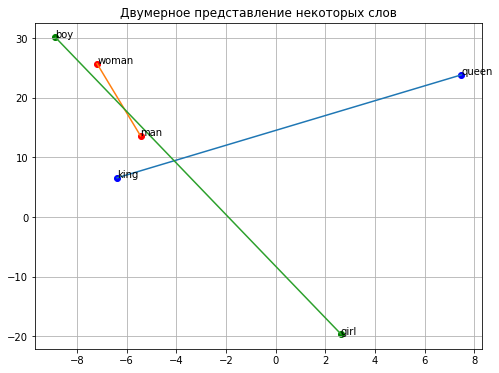

In [47]:
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.title('Двумерное представление некоторых слов')

plt.scatter(*emb_2dim[queen], c='b')
plt.scatter(*emb_2dim[king], c='b')
plt.scatter(*emb_2dim[man], c='r')
plt.scatter(*emb_2dim[woman], c='r')

plt.text(*emb_2dim[queen], 'queen')
plt.text(*emb_2dim[king], 'king')
plt.text(*emb_2dim[man], 'man')
plt.text(*emb_2dim[woman], 'woman')
plt.text(*emb_2dim[girl], 'girl')
plt.text(*emb_2dim[boy], 'boy')

plt.plot([emb_2dim[queen][0], emb_2dim[king][0]], [emb_2dim[queen][1], emb_2dim[king][1]])
plt.plot([emb_2dim[man][0], emb_2dim[woman][0]], [emb_2dim[man][1], emb_2dim[woman][1]])
plt.plot([emb_2dim[girl][0], emb_2dim[boy][0]], [emb_2dim[girl][1], emb_2dim[boy][1]])
plt.scatter(*emb_2dim[girl], c='g')
plt.scatter(*emb_2dim[boy], c='g')
plt.show()

Как видно, похожие слова оставляют желать лучшего, но зато вектора мальчик-девочка и мужчина-женщина практиечски параллельны, но встает вопрос почему они "перевернуты".

## 2ая модель

Размерность эмбединга - 500, размер окна - 3, минимум повторения слов - 2

In [ ]:
word_to_ind, ind_to_word, train_context, length = preparation(text, 2, 3)

model = CBOW(500, length)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

train(train_context)

In [92]:
fc2_cpu = model.fc2.state_dict()['weight'].to('cpu')
nbrs = NearestNeighbors(n_neighbors=2, metric='cosine').fit(fc2_cpu)

neighbors = nbrs.kneighbors(fc2_cpu[word_to_ind['women']].reshape(1, -1), n_neighbors=5)[1][0]
print('5 most similiar to word women: ', end=' ')
for neigh in neighbors:
    print(ind_to_word[neigh], end=', ')
print()

neighbors = nbrs.kneighbors(fc2_cpu[word_to_ind['woman']].reshape(1, -1), n_neighbors=5)[1][0]
print('5 most similiar to word woman: ', end=' ')
for neigh in neighbors:
    print(ind_to_word[neigh], end=', ')
print()

neighbors = nbrs.kneighbors(fc2_cpu[word_to_ind['boy']].reshape(1, -1), n_neighbors=5)[1][0]
print('5 most similiar to word boy: ', end=' ')
for neigh in neighbors:
    print(ind_to_word[neigh], end=', ')

5 most similiar to word women:  women, closer, agencys, nevada, widely, 
5 most similiar to word woman:  woman, raging, helicopter, upgrade, kan, 
5 most similiar to word boy:  boy, bomb, moving, seemingly, western, 

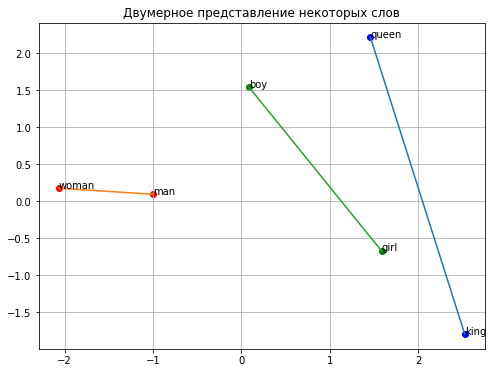

In [96]:
tsne = TSNE()

emb_2dim = tsne.fit_transform(fc2_cpu)
queen, king, man, woman = word_to_ind['queen'], word_to_ind['king'], word_to_ind['man'], word_to_ind['woman']
girl, boy = word_to_ind['girl'], word_to_ind['boy']


plt.figure(figsize=(8, 6))
plt.grid(True)
plt.title('Двумерное представление некоторых слов')

plt.scatter(*emb_2dim[queen], c='b')
plt.scatter(*emb_2dim[king], c='b')
plt.scatter(*emb_2dim[man], c='r')
plt.scatter(*emb_2dim[woman], c='r')

plt.text(*emb_2dim[queen], 'queen')
plt.text(*emb_2dim[king], 'king')
plt.text(*emb_2dim[man], 'man')
plt.text(*emb_2dim[woman], 'woman')
plt.text(*emb_2dim[girl], 'girl')
plt.text(*emb_2dim[boy], 'boy')

plt.plot([emb_2dim[queen][0], emb_2dim[king][0]], [emb_2dim[queen][1], emb_2dim[king][1]])
plt.plot([emb_2dim[man][0], emb_2dim[woman][0]], [emb_2dim[man][1], emb_2dim[woman][1]])
plt.plot([emb_2dim[girl][0], emb_2dim[boy][0]], [emb_2dim[girl][1], emb_2dim[boy][1]])
plt.scatter(*emb_2dim[girl], c='g')
plt.scatter(*emb_2dim[boy], c='g')
plt.show()

Ближайшие слова все также неинтерпретируемы, но теперь вектор мальчик-девочка стал ближе к король-королева, а вот мужчина-женщина вообще почему то стал ортогональным к ним

## 3ья модель

Размерность эмбединга - 2000, размер окна - 5, минимум повторения слов - 2

In [ ]:
word_to_ind, ind_to_word, train_context, length = preparation(text, 2, 5)

model = CBOW(2000, length)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

train(train_context)

In [99]:
fc2_cpu = model.fc2.state_dict()['weight'].to('cpu')
nbrs = NearestNeighbors(n_neighbors=2, metric='cosine').fit(fc2_cpu)

neighbors = nbrs.kneighbors(fc2_cpu[word_to_ind['women']].reshape(1, -1), n_neighbors=5)[1][0]
print('5 most similiar to word women: ', end=' ')
for neigh in neighbors:
    print(ind_to_word[neigh], end=', ')
print()

neighbors = nbrs.kneighbors(fc2_cpu[word_to_ind['woman']].reshape(1, -1), n_neighbors=5)[1][0]
print('5 most similiar to word woman: ', end=' ')
for neigh in neighbors:
    print(ind_to_word[neigh], end=', ')
print()

neighbors = nbrs.kneighbors(fc2_cpu[word_to_ind['boy']].reshape(1, -1), n_neighbors=5)[1][0]
print('5 most similiar to word boy: ', end=' ')
for neigh in neighbors:
    print(ind_to_word[neigh], end=', ')

5 most similiar to word women:  women, jamaica, cuttingedge, nathan, death, 
5 most similiar to word woman:  woman, lost, nintendo, gathered, massachusetts, 
5 most similiar to word boy:  boy, researcher, true, mix, chapter, 

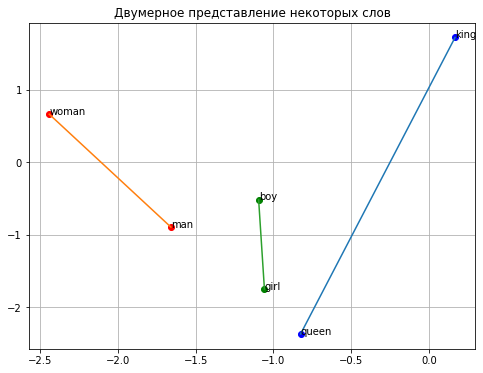

In [100]:
tsne = TSNE()

emb_2dim = tsne.fit_transform(fc2_cpu)
queen, king, man, woman = word_to_ind['queen'], word_to_ind['king'], word_to_ind['man'], word_to_ind['woman']
girl, boy = word_to_ind['girl'], word_to_ind['boy']


plt.figure(figsize=(8, 6))
plt.grid(True)
plt.title('Двумерное представление некоторых слов')

plt.scatter(*emb_2dim[queen], c='b')
plt.scatter(*emb_2dim[king], c='b')
plt.scatter(*emb_2dim[man], c='r')
plt.scatter(*emb_2dim[woman], c='r')

plt.text(*emb_2dim[queen], 'queen')
plt.text(*emb_2dim[king], 'king')
plt.text(*emb_2dim[man], 'man')
plt.text(*emb_2dim[woman], 'woman')
plt.text(*emb_2dim[girl], 'girl')
plt.text(*emb_2dim[boy], 'boy')

plt.plot([emb_2dim[queen][0], emb_2dim[king][0]], [emb_2dim[queen][1], emb_2dim[king][1]])
plt.plot([emb_2dim[man][0], emb_2dim[woman][0]], [emb_2dim[man][1], emb_2dim[woman][1]])
plt.plot([emb_2dim[girl][0], emb_2dim[boy][0]], [emb_2dim[girl][1], emb_2dim[boy][1]])
plt.scatter(*emb_2dim[girl], c='g')
plt.scatter(*emb_2dim[boy], c='g')
plt.show()

Кажется, что слова даже стали чуть получше, и вектора теперь даже почти сонаправлены

#Заключение

Первым делом хочется сказать, что, к сожалению, очень мало получилось уделить времени работе, поэтому себе бы я вообще 2 поставил. Следующие возможные действия, которые стоит сделать при должном количестве времени:

*   Реализовать модель skip-gram
*   Реализовать пакетное обучение
*   Реализовать различные методы ускорения по типу Negative Sampling
*   Провести покомпонентное сравнение векторов близких и далеких по смыслу векторов (heatmap)

В качетсве вывода данной работы могу сказать, что есть ощущение, что на маленьких корпусах текста, с малым количеством времени и малыми мощностями можно даже не пытаться обучать модель word2vec. Ей требуется много времени и много примеров для обучения. Также временами катастрофически не хватает памяти видеокарты.

Получившиеся у меня представления в принципе иногда даже коллинеарны в двумерном виде, однако, судя по ближайшим похожим, до реального рабочего вида им еще очень далеко
